In [50]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import pickle

In [6]:
import os

In [118]:
path = os.getcwd()
df = pd.read_csv(path+"/data/train.csv")
stores = pd.read_csv(path+"/data/stores.csv")

In [4]:
df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0.0
1,1,2013-01-01,1,BABY CARE,0.0,0.0
2,2,2013-01-01,1,BEAUTY,0.0,0.0
3,3,2013-01-01,1,BEVERAGES,0.0,0.0
4,4,2013-01-01,1,BOOKS,0.0,0.0


In [5]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [6]:
stores.store_nbr.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54])

In [7]:
df.shape

(3000888, 6)

In [8]:
df.family.unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [9]:
df.date.dtype

dtype('O')

In [119]:
df.date = pd.to_datetime(df.date)

In [11]:
df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0.0
1,1,2013-01-01,1,BABY CARE,0.0,0.0
2,2,2013-01-01,1,BEAUTY,0.0,0.0
3,3,2013-01-01,1,BEVERAGES,0.0,0.0
4,4,2013-01-01,1,BOOKS,0.0,0.0


In [12]:
df.date.min()

Timestamp('2013-01-01 00:00:00')

In [13]:
df.date.max()

Timestamp('2017-08-15 00:00:00')

In [14]:
df.store_nbr.unique()

array([ 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,  2, 20, 21, 22, 23, 24,
       25, 26, 27, 28, 29,  3, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,  4,
       40, 41, 42, 43, 44, 45, 46, 47, 48, 49,  5, 50, 51, 52, 53, 54,  6,
        7,  8,  9])

In [15]:
df.onpromotion.min()

0.0

In [16]:
df.onpromotion.max()

1006.0

In [54]:
df.sales.max()

124717.0

# Preprocessing

## Removing missing data

There is no missing data in the train dat set.

In [ ]:
df.isnull().any(axis = 1).any()

In [ ]:
df.dropna(how='any',inplace=True)
df.shape

## One-hot encoding for catogorical features

In [17]:
df_oh=pd.get_dummies(df, prefix='', prefix_sep='')
df_oh.head()

,id,date,store_nbr,sales,onpromotion,AUTOMOTIVE,BABY CARE,BEAUTY,BEVERAGES,BOOKS,...,MAGAZINES,MEATS,PERSONAL CARE,PET SUPPLIES,PLAYERS AND ELECTRONICS,POULTRY,PREPARED FOODS,PRODUCE,SCHOOL AND OFFICE SUPPLIES,SEAFOOD
0,0,2013-01-01,1,0.0,0.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,2013-01-01,1,0.0,0.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,2013-01-01,1,0.0,0.0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,2013-01-01,1,0.0,0.0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,4,2013-01-01,1,0.0,0.0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


## Joining store information from stores table

In [120]:
df = pd.merge(df,stores, how = 'inner', on='store_nbr')
df.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0.0,Quito,Pichincha,D,13
1,1,2013-01-01,1,BABY CARE,0.0,0.0,Quito,Pichincha,D,13
2,2,2013-01-01,1,BEAUTY,0.0,0.0,Quito,Pichincha,D,13
3,3,2013-01-01,1,BEVERAGES,0.0,0.0,Quito,Pichincha,D,13
4,4,2013-01-01,1,BOOKS,0.0,0.0,Quito,Pichincha,D,13


In [11]:
families = list(df.family.unique())

In [ ]:
df.loc[0,'date']

## Removing outlier

let's compare all families of products at store one near earth quake with no promotion to see the effect of the earthquake.

In [ ]:
df[(df['store_nbr']==1)&(df['date']==pd.Timestamp(2014,4,1,0))].shape

In [20]:
EQ_time = pd.Timestamp(2016,4,16,0)
#end = pd.Timestamp(2016,7,16,0)
#store1_nearEQ = df[(df['store_nbr']==1) & (df['onpromotion']>300.0)&(df['date']>=start)&(df['date']<end)]

In [ ]:
store1_nearEQ.head()

# Exploratory feature analysis

## Explore the impact of the promotions on the product sales

Before going into all the details of seasonality and trends and lags, and adding all the time series features, let's take a look at how other features influence the product sales.

First I want to know what is the trend of sales numbers in each product category and compare it with the promotions.

In [80]:
promo_allT = pd.DataFrame(df.groupby(['family'])['onpromotion'].sum())

In [81]:
promo_allT = promo_allT.reset_index()

In [82]:
sales_allT = pd.DataFrame(df.groupby(['family'])['sales'].sum())

In [83]:
sales_allT = sales_allT.reset_index()

In [28]:
df_allT = pd.merge(promo_allT, sales_allT, how = 'inner', on='family')

In [30]:
df_allT = df_allT.sort_values(by='onpromotion')
df_allT.head()

,family,onpromotion,sales
4,BOOKS,2772.0,6438.0
1,BABY CARE,5294.0,10051.0
17,HOME APPLIANCES,16975.0,41601.0
14,HARDWARE,53827.0,103470.0
31,SCHOOL AND OFFICE SUPPLIES,62415.0,269316.0


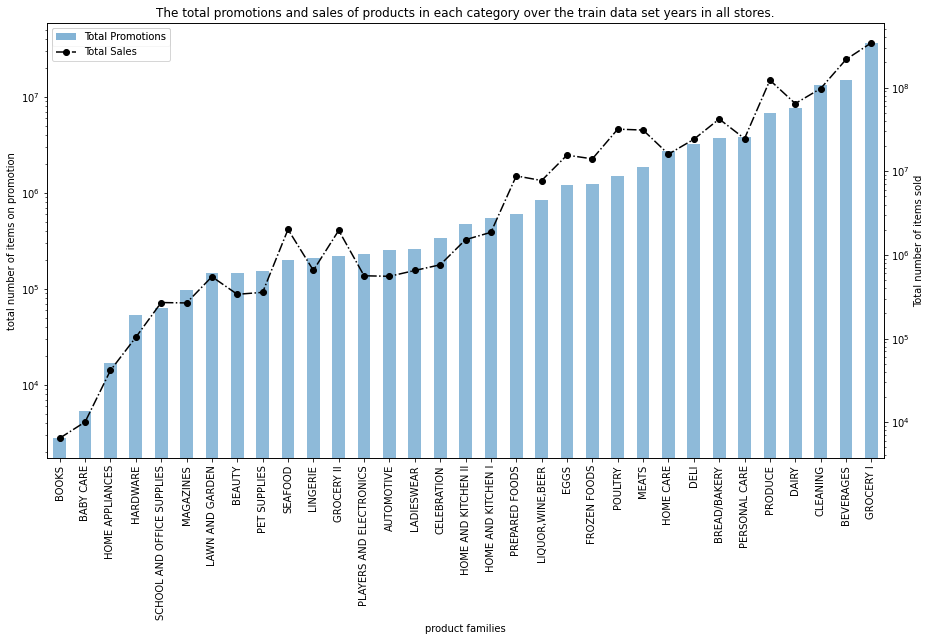

In [72]:
ax = df_allT.plot(kind='bar',figsize=(15,8),x='family',y='onpromotion', alpha = 0.5,label='Total Promotions')
ax.set_xlabel('product families')
ax.set_ylabel('total number of items on promotion')
ax.set_yscale('log')

ax2 = ax.twinx()
ax2.plot(df_allT['family'],df_allT['sales'], marker='o',ls='-.',c='k',label='Total Sales')
ax2.set_ylabel('Total number of items sold')
ax2.set_yscale('log')

# ask matplotlib for the plotted objects and their labels
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

plt.title("The total promotions and sales of products in each category over the train data set years in all stores.")
plt.show()

Seems like that the product categories with more promotions sell better. So does it mean that more promotions lead to more sales, or maybe those popular products naturally get more promotions and exposures?

In [44]:
df_pdist = pd.DataFrame(df.groupby(['date','family'])['onpromotion'].sum()).reset_index()
df_sdist = pd.DataFrame(df.groupby(['date','family'])['sales'].sum()).reset_index()

In [45]:
df_sdist.head()

,date,family,sales
0,2013-01-01,AUTOMOTIVE,0.0
1,2013-01-01,BABY CARE,0.0
2,2013-01-01,BEAUTY,2.0
3,2013-01-01,BEVERAGES,810.0
4,2013-01-01,BOOKS,0.0


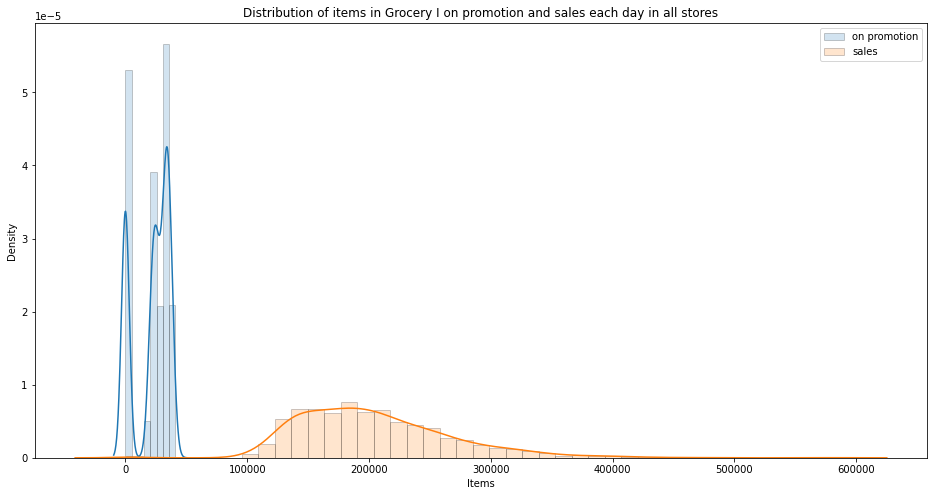

In [85]:
hist_kws = {'histtype':'bar', 'edgecolor':'black', 'alpha': 0.2}

plt.figure(figsize=(16,8))

sns.distplot(df_pdist[df['family'] == 'GROCERY I']['onpromotion'], label='on promotion', hist_kws = hist_kws)
sns.distplot(df_sdist[df['family'] == 'GROCERY I']['sales'], label='sales', hist_kws = hist_kws)
plt.legend()
plt.title('Distribution of items in Grocery I on promotion and sales each day in all stores')
plt.xlabel('Items');


In [178]:
max5_sold_families = list(df_allT.iloc[-5:,0])
min10_sold_families = list(df_allT.iloc[0:11,0])
eleven2twenty8 = list(df_allT.iloc[11:29,0])

In [63]:
max5_sold_families

['PRODUCE', 'DAIRY', 'CLEANING', 'BEVERAGES', 'GROCERY I']

In [176]:
min10_sold_families

['BOOKS',
 'BABY CARE',
 'HOME APPLIANCES',
 'HARDWARE',
 'SCHOOL AND OFFICE SUPPLIES',
 'MAGAZINES',
 'LAWN AND GARDEN',
 'BEAUTY',
 'PET SUPPLIES',
 'SEAFOOD',
 'LINGERIE']

Text(0.5, 0, 'Items')

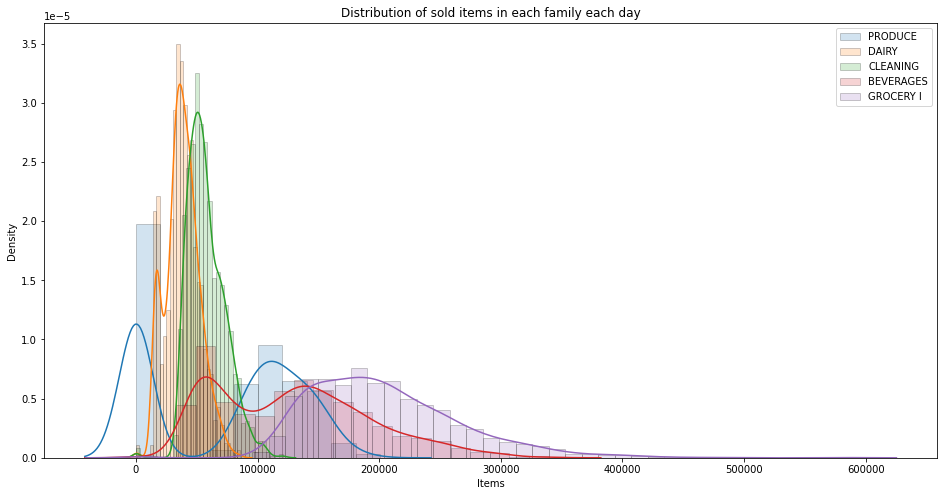

In [65]:
hist_kws = {'histtype':'bar', 'edgecolor':'black', 'alpha': 0.2}

plt.figure(figsize=(16,8))
for family in max5_sold_families:
    sns.distplot(df_sdist[df['family'] == family]['sales'], label=family, hist_kws = hist_kws)

plt.legend()
plt.title('Distribution of sold items in each family each day')
plt.xlabel('Items')
#plt.xscale('log')

In [139]:
# df2 = df.copy()
# df2['onpromotion'] = pd.cut(df2['onpromotion'],[0.0,100,200,300,400,500,600,700,800,900,1006.0],include_lowest =True)

In [166]:
df.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0.0,Quito,Pichincha,D,13
1,1,2013-01-01,1,BABY CARE,0.0,0.0,Quito,Pichincha,D,13
2,2,2013-01-01,1,BEAUTY,0.0,0.0,Quito,Pichincha,D,13
3,3,2013-01-01,1,BEVERAGES,0.0,0.0,Quito,Pichincha,D,13
4,4,2013-01-01,1,BOOKS,0.0,0.0,Quito,Pichincha,D,13


In [167]:
mean_sales = pd.DataFrame(df.groupby(['family','onpromotion'])['sales'].mean()).reset_index()

In [168]:
mean_sales.head()

,family,onpromotion,sales
0,AUTOMOTIVE,0.0,3.815307
1,AUTOMOTIVE,1.0,1.430927
2,AUTOMOTIVE,2.0,2.983124
3,AUTOMOTIVE,3.0,4.572786
4,AUTOMOTIVE,4.0,6.274716


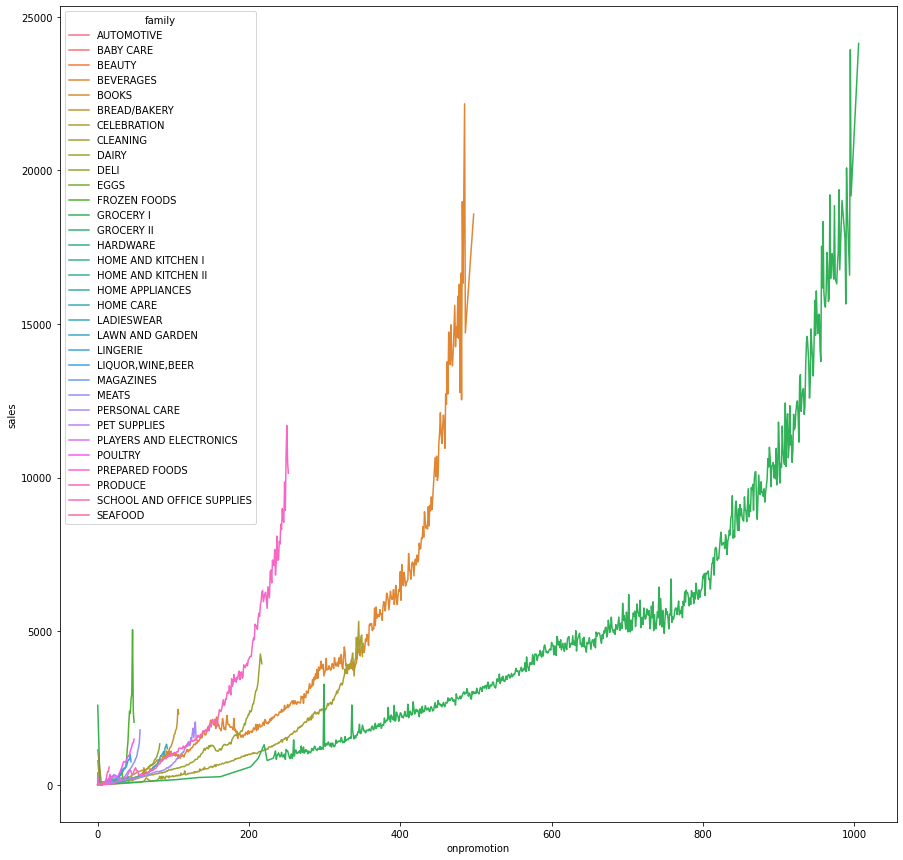

In [173]:
fig,ax = plt.subplots(figsize=(15,15))
sns.lineplot(data=mean_sales, x="onpromotion", y="sales", hue="family")
plt.show()

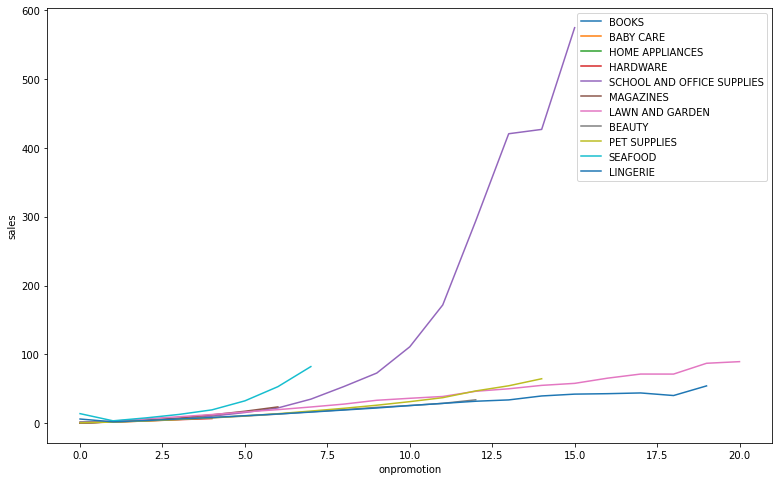

In [185]:
fig,ax = plt.subplots(figsize=(13,8))
for family in min10_sold_families:
    sns.lineplot(data=mean_sales[mean_sales['family']==family], x="onpromotion", y="sales",label=family)
plt.legend()
plt.show()


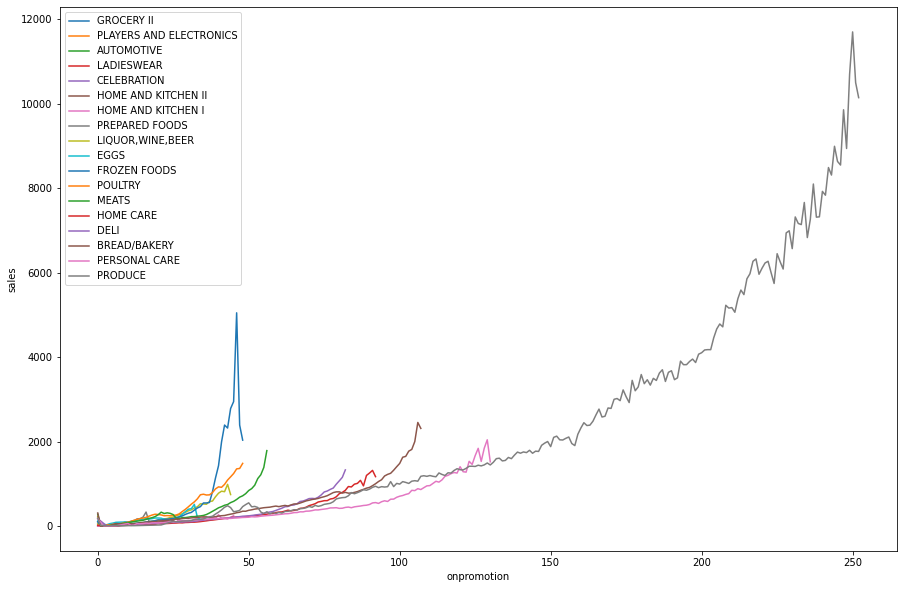

In [183]:
fig,ax = plt.subplots(figsize=(15,10))
for family in eleven2twenty8:
    sns.lineplot(data=mean_sales[mean_sales['family']==family], x="onpromotion", y="sales",label = family)
plt.legend()
plt.show()

In [ ]:
## see whether there is lagged response of promotions on sales

In [21]:
store1_nopromo = df[(df['store_nbr']==1) & (df['onpromotion']==0) & (df['date']<EQ_time)]

In [22]:
store1_promoL = df[(df['store_nbr']==1) & (df['onpromotion']>400) & (df['date']<EQ_time)]

In [23]:
store1_promoL.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster
14994,809040,2014-04-01,1,GROCERY I,2471.0,495.0,Quito,Pichincha,D,13
15027,810822,2014-04-02,1,GROCERY I,2685.0,495.0,Quito,Pichincha,D,13
15060,812604,2014-04-03,1,GROCERY I,1904.0,447.0,Quito,Pichincha,D,13
15093,814386,2014-04-04,1,GROCERY I,2855.0,470.0,Quito,Pichincha,D,13
15126,816168,2014-04-05,1,GROCERY I,2251.0,468.0,Quito,Pichincha,D,13


In [ ]:
store1_nopromo.head()

In [ ]:
## Total promotion on each category

In [ ]:
store1_nopromo.loc[0,'AUTOMOTIVE'] == 1

In [ ]:
families = list(store1_nopromo.columns)
families = families[5:38]

In [ ]:
fig, ax = plt.subplots(figsize=(11,10))
plt.plot(store1_promoL[store1_promoL[families[5]]==1]['date'],store1_promoL[store1_promoL[families[5]]==1]['sales'])
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Sales with large promotion of each product family in store #1')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(11,10))
plt.plot(store1_nopromo[store1_nopromo[families[0]]==1]['date'],store1_nopromo[store1_nopromo[families[0]]==1]['sales'])
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Sales with no promotion of each product family in store #1')
plt.show()
